Required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import json
from collections import Counter, defaultdict
import torch
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import umap
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import os
import warnings
warnings.filterwarnings('ignore')

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def download_hatexplain_data():
    """Download HateXplain main dataset from GitHub repository"""
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    # os.makedirs: Creates a folder
    # 'data': Folder name
    # exist_ok=True: Don't error if folder already exists
    
    # URL to the raw dataset on GitHub
    dataset_url = 'https://raw.githubusercontent.com/hate-alert/HateXplain/master/Data/dataset.json'
    
    print("Downloading HateXplain main dataset...")
    
    # Send HTTP GET request to download the file
    response = requests.get(dataset_url)
    # response: Contains the downloaded data
    
    # Check if download was successful (status code 200)
    response.raise_for_status()
    # Raises error if status code is not 200 (success)
    
    # Parse the JSON text into a Python dictionary
    dataset = json.loads(response.text)
    # json.loads: Converts JSON string to Python dictionary
    # response.text: The raw text content from the download
    
    print(f"✓ Successfully downloaded dataset: {len(dataset)} samples")
    # f-string: Formats the string with variable values
    # len(dataset): Counts number of posts in the dataset
    
    # Save the raw data locally as backup
    with open('data/hatexplain_raw.json', 'w') as f:
        # 'with open': Opens file, automatically closes when done
        # 'w': Write mode (creates new file or overwrites existing)
        # 'as f': Assigns file object to variable 'f'
        json.dump(dataset, f, indent=2)
        # json.dump: Writes Python object as JSON to file
        # indent=2: Makes JSON human-readable with 2-space indentation
    
    print("✓ Raw data saved to 'data/hatexplain_raw.json'")
    
    return dataset  # Return the dataset for use in next cells
        

# Call the function to download the data
raw_dataset = download_hatexplain_data()

print(f"\n✓ Dataset download complete!")
print(f"✓ Total samples available: {len(raw_dataset)}")
print("✓ Ready for data processing")

# Show sample structure to understand the data format
if raw_dataset:
    sample_key = list(raw_dataset.keys())[0]  # Get first post ID
    sample = raw_dataset[sample_key]  # Get first post data
    print(f"\nSample data structure:")
    print(f"  Post ID: {sample.get('post_id', 'N/A')}")
    # .get('key', 'default'): Gets value or returns default if key doesn't exist
    print(f"  Tokens: {len(sample.get('post_tokens', []))} tokens")
    print(f"  Annotators: {len(sample.get('annotators', []))}")
    print(f"  Rationales: {len(sample.get('rationales', []))} sets")


✓ Successfully downloaded dataset: 20148 samples
✓ Raw data saved to 'data/hatexplain_raw.json'

✓ Dataset download complete!
✓ Total samples available: 20148
✓ Ready for data processing

Sample data structure:
  Post ID: 1179055004553900032_twitter
  Tokens: 20 tokens
  Annotators: 3
  Rationales: 0 sets


In [4]:
# Examine the actual tokens
sample_key = list(raw_dataset.keys())[0]
sample = raw_dataset[sample_key]
print("Actual tokens:", sample.get('post_tokens', []))
print("Token count:", len(sample.get('post_tokens', [])))

Actual tokens: ['i', 'dont', 'think', 'im', 'getting', 'my', 'baby', 'them', 'white', '9', 'he', 'has', 'two', 'white', 'j', 'and', 'nikes', 'not', 'even', 'touched']
Token count: 20


In [5]:
def convert_to_dataframe(raw_data):
    """Convert raw HateXplain data to pandas DataFrame"""
    
    # Map string labels to numbers for easier processing
    label_mapping = {
        'hatespeech': 0,  # Hate speech gets number 0
        'normal': 1,      # Normal text gets number 1
        'offensive': 2    # Offensive language gets number 2
    }
    
    processed_data = []  # Empty list to store processed samples
    
    # Loop through each post in the dataset
    for post_id, sample in raw_data.items():
        # post_id: The unique ID (e.g., "24198545_gab")
        # sample: The post data (dictionary with tokens, annotators, etc.)
        
        # Initialize lists to collect labels and targets from all annotators
        labels = []
        targets = []
        
        # Loop through each annotator's judgment for this post
        for ann in sample['annotators']:
            # ann: Dictionary with 'label', 'annotator_id', 'target'
            
            # Convert string label to number using mapping
            label_str = ann['label'].lower()  # Convert to lowercase
            label_num = label_mapping.get(label_str, 1)  # Get number, default to 'normal' if unknown
            labels.append(label_num)  # Add to list of labels
            
            # Collect target communities mentioned
            if 'target' in ann:
                targets.extend(ann['target'])  # Add all targets to list
                # extend: Adds each item individually (vs append which adds whole list)
        
        # Calculate majority label (most common label from annotators)
        label_counts = Counter(labels)
        # Counter: Creates dictionary of {label: count}
        # Example: Counter([0, 0, 1]) = {0: 2, 1: 1}
        
        majority_label = label_counts.most_common(1)[0][0]
        # most_common(1): Gets [(label, count)] for most frequent
        # [0][0]: Gets just the label (first element of first tuple)
        
        confidence = label_counts[majority_label] / len(labels)
        # confidence: What fraction of annotators agreed?
        # Example: 2 out of 3 agreed = 2/3 = 0.667
        
        # Process rationales (which tokens are important)
        rationales = sample['rationales']
        rationale_agreement = []  # Will store agreement score for each token
        
        if rationales:
            # Loop through each token position
            for token_idx in range(len(sample['post_tokens'])):
                if token_idx < len(rationales[0]):
                    # Count how many annotators marked this token as rationale
                    votes = sum(1 for rat in rationales 
                               if token_idx < len(rat) and rat[token_idx] == 1)
                    # sum with generator: Counts True values
                    # rat[token_idx] == 1: Check if this annotator marked it
                    
                    agreement = votes / len(rationales)
                    # agreement: Fraction of annotators who marked this token
                    # Example: 2 out of 3 marked it = 2/3 = 0.667
                    rationale_agreement.append(agreement)
                else:
                    rationale_agreement.append(0)  # No rationale for this token
        else:
            # No rationales provided, all zeros
            rationale_agreement = [0] * len(sample['post_tokens'])
        
        # Create processed sample dictionary
        processed_data.append({
            'id': post_id,  # Original post ID
            'tokens': sample['post_tokens'],  # List of words
            'text': ' '.join(sample['post_tokens']),  # Full text as string
            'label': majority_label,  # Numeric label (0, 1, or 2)
            'label_name': ['hate', 'normal', 'offensive'][majority_label],  # String name
            'confidence': confidence,  # Agreement level (0.0 to 1.0)
            'targets': list(set(targets)) if targets else [],  # Unique targets
            # set(targets): Removes duplicates
            # list(...): Converts back to list
            'rationale_agreement': rationale_agreement,  # Agreement per token
            'num_annotators': len(labels),  # How many people annotated
            'text_length': len(sample['post_tokens']),  # Number of words
            'has_rationales': sum(sum(rat) for rat in rationales) > 0 if rationales else False
            # Checks if any rationale exists (any 1 in any rationale array)
        })
    
    # Convert list of dictionaries to DataFrame
    return pd.DataFrame(processed_data)
    # DataFrame: Like an Excel table with rows and columns

# Convert to DataFrame
print("Converting data to pandas DataFrame...")
df = convert_to_dataframe(raw_dataset)

print(f"✓ Conversion complete: {len(df)} samples")
print(f"✓ Columns: {list(df.columns)}")


Converting data to pandas DataFrame...
✓ Conversion complete: 20148 samples
✓ Columns: ['id', 'tokens', 'text', 'label', 'label_name', 'confidence', 'targets', 'rationale_agreement', 'num_annotators', 'text_length', 'has_rationales']


In [6]:
# Display DataFrame features and sample data
print("DataFrame Overview:")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print()

print("First 3 rows:")
print("=" * 50)
print(df.head(3))
print()

print("Label distribution:")
print("=" * 50)
print(df['label_name'].value_counts())
print()

print("Sample post details:")
print("=" * 50)
sample_row = df.iloc[0]
print(f"ID: {sample_row['id']}")
print(f"Text: {sample_row['text']}")
print(f"Label: {sample_row['label_name']} (confidence: {sample_row['confidence']:.2f})")
print(f"Tokens: {sample_row['tokens']}")
print(f"Targets: {sample_row['targets']}")
print(f"Text length: {sample_row['text_length']} words")
print(f"Has rationales: {sample_row['has_rationales']}")
print(f"Rationale agreement: {sample_row['rationale_agreement'][:10]}...")  # First 10 tokens

DataFrame Overview:
Shape: (20148, 11)
Columns: ['id', 'tokens', 'text', 'label', 'label_name', 'confidence', 'targets', 'rationale_agreement', 'num_annotators', 'text_length', 'has_rationales']

First 3 rows:
                            id  \
0  1179055004553900032_twitter   
1  1179063826874032128_twitter   
2  1178793830532956161_twitter   

                                              tokens  \
0  [i, dont, think, im, getting, my, baby, them, ...   
1  [we, cannot, continue, calling, ourselves, fem...   
2                [nawt, yall, niggers, ignoring, me]   

                                                text  label label_name  \
0  i dont think im getting my baby them white 9 h...      1     normal   
1  we cannot continue calling ourselves feminists...      1     normal   
2                      nawt yall niggers ignoring me      1     normal   

   confidence          targets  \
0    1.000000           [None]   
1    1.000000           [None]   
2    0.666667  [None, African

In [7]:
# Basic dataset statistics
print("=== HATEXPLAIN DATASET OVERVIEW ===")
print(f"Total samples: {len(df)}")
print(f"Average text length: {df['text_length'].mean():.1f} tokens")
print(f"Samples with rationales: {df['has_rationales'].sum()}")

print("\nLabel Distribution:")
label_counts = df['label_name'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

print("\nConfidence Distribution:")
print(f"  Mean confidence: {df['confidence'].mean():.3f}")
print(f"  Min confidence: {df['confidence'].min():.3f}")
print(f"  Max confidence: {df['confidence'].max():.3f}")

print("\nText Length Statistics:")
print(f"  Min length: {df['text_length'].min()} tokens")
print(f"  Max length: {df['text_length'].max()} tokens")
print(f"  Median length: {df['text_length'].median():.0f} tokens")

print("\nSample entries:")
print(df[['text', 'label_name', 'confidence', 'targets']].head())


=== HATEXPLAIN DATASET OVERVIEW ===
Total samples: 20148
Average text length: 23.6 tokens
Samples with rationales: 11413

Label Distribution:
  normal: 8153 (40.5%)
  hate: 6234 (30.9%)
  offensive: 5761 (28.6%)

Confidence Distribution:
  Mean confidence: 0.814
  Min confidence: 0.333
  Max confidence: 1.000

Text Length Statistics:
  Min length: 2 tokens
  Max length: 165 tokens
  Median length: 21 tokens

Sample entries:
                                                text label_name  confidence  \
0  i dont think im getting my baby them white 9 h...     normal    1.000000   
1  we cannot continue calling ourselves feminists...     normal    1.000000   
2                      nawt yall niggers ignoring me     normal    0.666667   
3  <user> i am bit confused coz chinese ppl can n...       hate    0.666667   
4  this bitch in whataburger eating a burger with...       hate    0.666667   

              targets  
0              [None]  
1              [None]  
2     [None, African]  
3

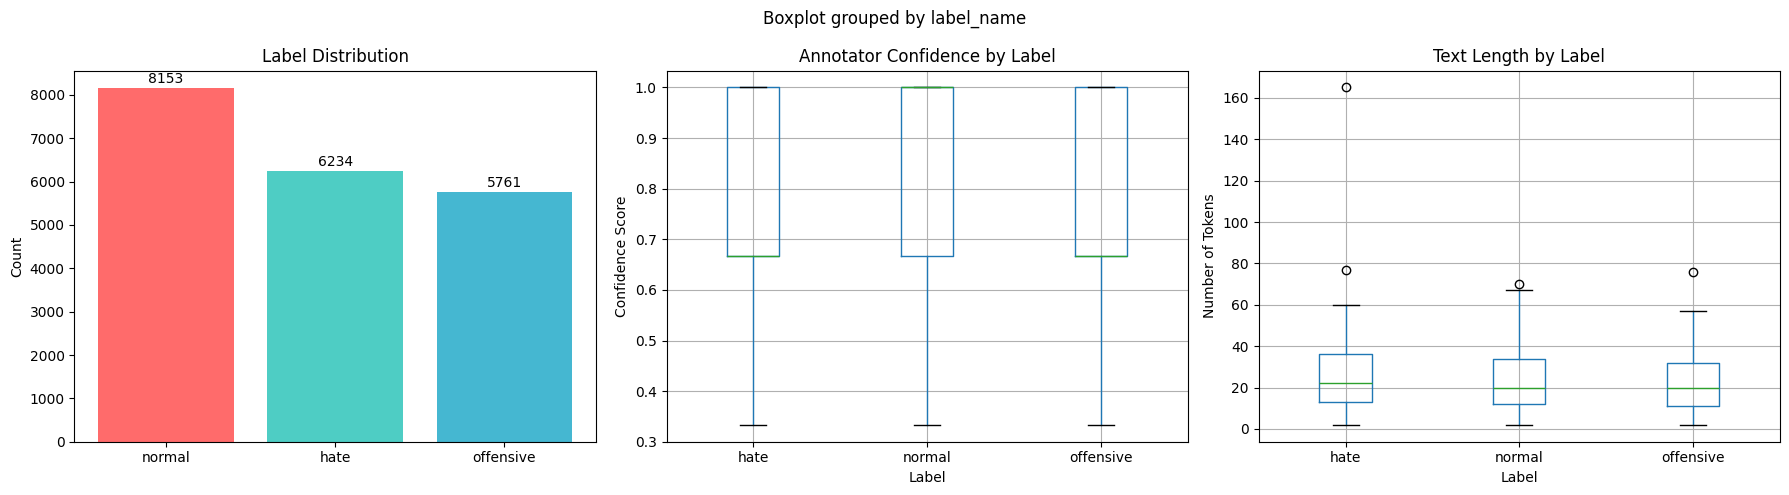

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Basic label counts
label_counts = df['label_name'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[0].bar(label_counts.index, label_counts.values, color=colors)
axes[0].set_title('Label Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom')

# 2. Confidence by label
df.boxplot(column='confidence', by='label_name', ax=axes[1])
axes[1].set_title('Annotator Confidence by Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Confidence Score')

# 3. Text length by label
df.boxplot(column='text_length', by='label_name', ax=axes[2])
axes[2].set_title('Text Length by Label')
axes[2].set_xlabel('Label') 
axes[2].set_ylabel('Number of Tokens')

plt.tight_layout()
plt.show()


In [9]:
def analyze_target_groups(df):
    target_counts = Counter()
    target_by_label = defaultdict(Counter)
    
    for _, row in df.iterrows():
        for target in row['targets']:
            target_counts[target] += 1
            target_by_label[row['label_name']][target] += 1
    
    return target_counts, target_by_label

target_counts, target_by_label = analyze_target_groups(df)

print("=== TARGET GROUP ANALYSIS ===")
print(f"Total unique target groups: {len(target_counts)}")
print(f"Posts with targets: {df[df['targets'].str.len() > 0].shape[0]}")

print("\nMost frequent target groups:")
for target, count in target_counts.most_common(10):
    print(f"  {target}: {count}")

print("\nTarget distribution by label:")
for label in ['hate', 'normal', 'offensive']:
    print(f"\n{label.upper()}:")
    for target, count in target_by_label[label].most_common(5):
        print(f"  {target}: {count}")

globals()['target_counts'] = target_counts
globals()['target_by_label'] = target_by_label


=== TARGET GROUP ANALYSIS ===
Total unique target groups: 25
Posts with targets: 20148

Most frequent target groups:
  None: 10772
  African: 4468
  Women: 3926
  Other: 3702
  Islam: 3201
  Homosexual: 2596
  Jewish: 2543
  Arab: 1784
  Refugee: 1701
  Caucasian: 1698

Target distribution by label:

HATE:
  African: 2630
  Islam: 1648
  Jewish: 1631
  Women: 1106
  Arab: 1035

NORMAL:
  None: 7355
  Women: 1088
  Other: 1030
  African: 744
  Homosexual: 680

OFFENSIVE:
  None: 2476
  Other: 1750
  Women: 1732
  African: 1094
  Homosexual: 994


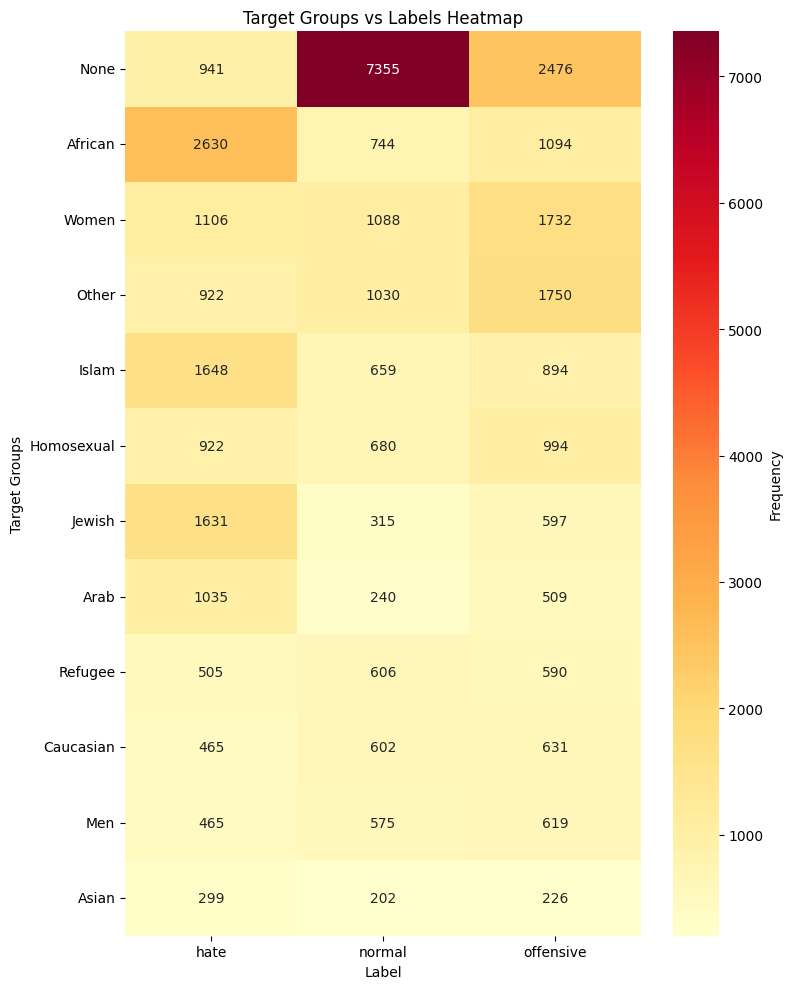

✓ Target group heatmap complete


In [10]:
def create_target_heatmap(target_counts, target_by_label):
    top_targets = list(dict(target_counts.most_common(12)).keys())
    labels = ['hate', 'normal', 'offensive']
    
    target_matrix = []
    for target in top_targets:
        row = [target_by_label[label][target] for label in labels]
        target_matrix.append(row)
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(target_matrix, 
                xticklabels=labels,
                yticklabels=top_targets,
                annot=True, fmt='d', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Frequency'})
    
    plt.title('Target Groups vs Labels Heatmap')
    plt.xlabel('Label')
    plt.ylabel('Target Groups')
    plt.tight_layout()
    plt.show()

create_target_heatmap(target_counts, target_by_label)
print("✓ Target group heatmap complete")


In [11]:
def analyze_rationale_patterns(df):
    rationale_stats = []
    
    for _, row in df.iterrows():
        tokens = row['tokens']
        rationale_agreement = row['rationale_agreement']
        
        rationale_tokens = [i for i, agreement in enumerate(rationale_agreement) if agreement > 0.5]
        
        if rationale_tokens:
            rationale_density = len(rationale_tokens) / len(tokens)
            avg_position = np.mean(rationale_tokens) / len(tokens)
            max_agreement = max(rationale_agreement)
        else:
            rationale_density = 0
            avg_position = 0.5
            max_agreement = 0
        
        rationale_stats.append({
            'label': row['label_name'],
            'rationale_density': rationale_density,
            'avg_position': avg_position,
            'max_agreement': max_agreement,
            'has_rationales': len(rationale_tokens) > 0
        })
    
    return pd.DataFrame(rationale_stats)

rationale_df = analyze_rationale_patterns(df)

print("=== RATIONALE ANALYSIS ===")
print(f"Samples with rationales: {rationale_df['has_rationales'].sum()}")
print(f"Average rationale density: {rationale_df['rationale_density'].mean():.3f}")

print("\nRationale statistics by label:")
for label in ['hate', 'normal', 'offensive']:
    label_data = rationale_df[rationale_df['label'] == label]
    print(f"\n{label.upper()}:")
    print(f"  Avg density: {label_data['rationale_density'].mean():.3f}")
    print(f"  Avg position: {label_data['avg_position'].mean():.3f}")
    print(f"  With rationales: {label_data['has_rationales'].sum()}")

globals()['rationale_df'] = rationale_df


=== RATIONALE ANALYSIS ===
Samples with rationales: 11071
Average rationale density: 0.098

Rationale statistics by label:

HATE:
  Avg density: 0.167
  Avg position: 0.523
  With rationales: 5863

NORMAL:
  Avg density: 0.000
  Avg position: 0.500
  With rationales: 0

OFFENSIVE:
  Avg density: 0.161
  Avg position: 0.538
  With rationales: 5208


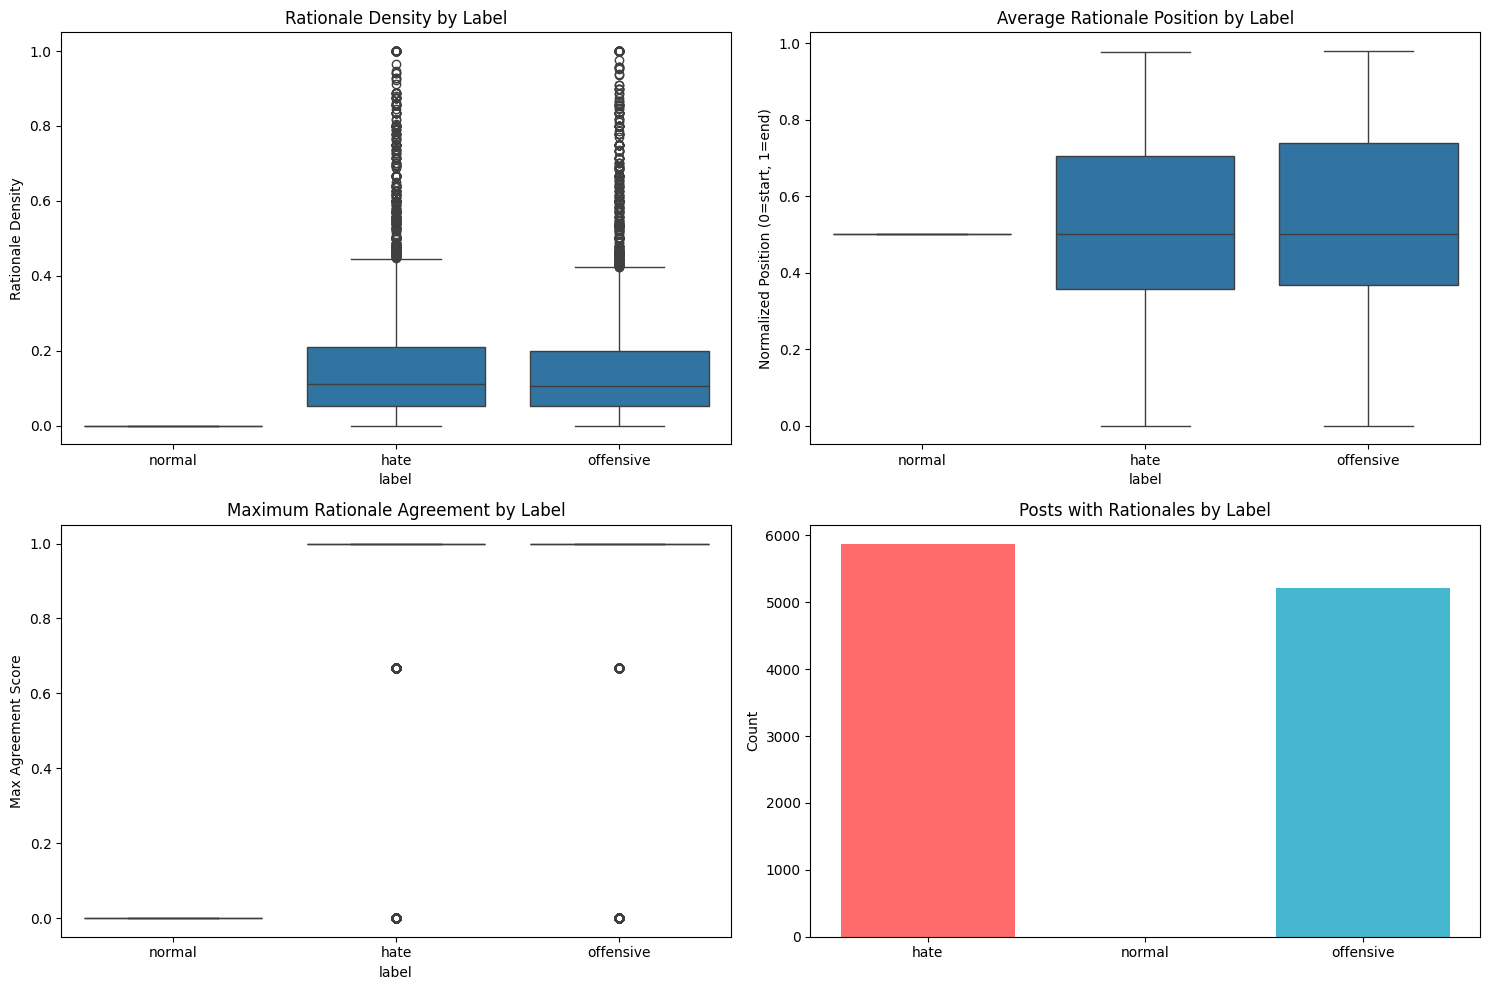

✓ Rationale pattern visualization complete


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rationale density by label
sns.boxplot(data=rationale_df, x='label', y='rationale_density', ax=axes[0,0])
axes[0,0].set_title('Rationale Density by Label')
axes[0,0].set_ylabel('Rationale Density')

# 2. Rationale position by label
sns.boxplot(data=rationale_df, x='label', y='avg_position', ax=axes[0,1])
axes[0,1].set_title('Average Rationale Position by Label')
axes[0,1].set_ylabel('Normalized Position (0=start, 1=end)')

# 3. Max agreement by label
sns.boxplot(data=rationale_df, x='label', y='max_agreement', ax=axes[1,0])
axes[1,0].set_title('Maximum Rationale Agreement by Label')
axes[1,0].set_ylabel('Max Agreement Score')

# 4. Rationale presence by label
rationale_presence = rationale_df.groupby('label')['has_rationales'].sum()
axes[1,1].bar(rationale_presence.index, rationale_presence.values, 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1,1].set_title('Posts with Rationales by Label')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("✓ Rationale pattern visualization complete")


In [12]:
print("Creating semantic embeddings...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Sample subset for computational efficiency
sample_size = 20148
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42).copy()

# Generate embeddings
embeddings = sentence_model.encode(df_sample['text'].tolist(), 
                                   show_progress_bar=True)

print(f"✓ Created embeddings for {len(df_sample)} samples")
print(f"✓ Embedding dimension: {embeddings.shape[1]}")

# Store embeddings and sample
globals()['embeddings'] = embeddings
globals()['df_sample'] = df_sample


Creating semantic embeddings...


Batches: 100%|██████████| 630/630 [01:07<00:00,  9.31it/s]


✓ Created embeddings for 20148 samples
✓ Embedding dimension: 384


In [13]:
!pip install nbformat



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
print("Reducing dimensions with UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_2d = reducer.fit_transform(embeddings)

# After UMAP reduction
df_umap = df_sample.copy()
df_umap['umap_x'] = embedding_2d[:, 0]
df_umap['umap_y'] = embedding_2d[:, 1]


# Recommended version (will never throw the ValueError)
fig = px.scatter(
    data_frame=df_umap,
    x='umap_x',
    y='umap_y',
    color='label_name',
    size='text_length',
    hover_data=['confidence'],
    title='Semantic Embedding Space of HateXplain Data',
    color_discrete_map={'hate': '#FF6B6B', 'normal': '#4ECDC4', 'offensive': '#45B7D1'},
    labels={'umap_x': 'UMAP Dimension 1', 'umap_y': 'UMAP Dimension 2'}
)
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=0.5, color='white')))
fig.update_layout(width=900, height=600)
fig.show()


# Add coordinates to sample dataframe
df_sample['embedding_x'] = embedding_2d[:, 0]
df_sample['embedding_y'] = embedding_2d[:, 1]

print("✓ Semantic space visualization complete")


Reducing dimensions with UMAP...


✓ Semantic space visualization complete


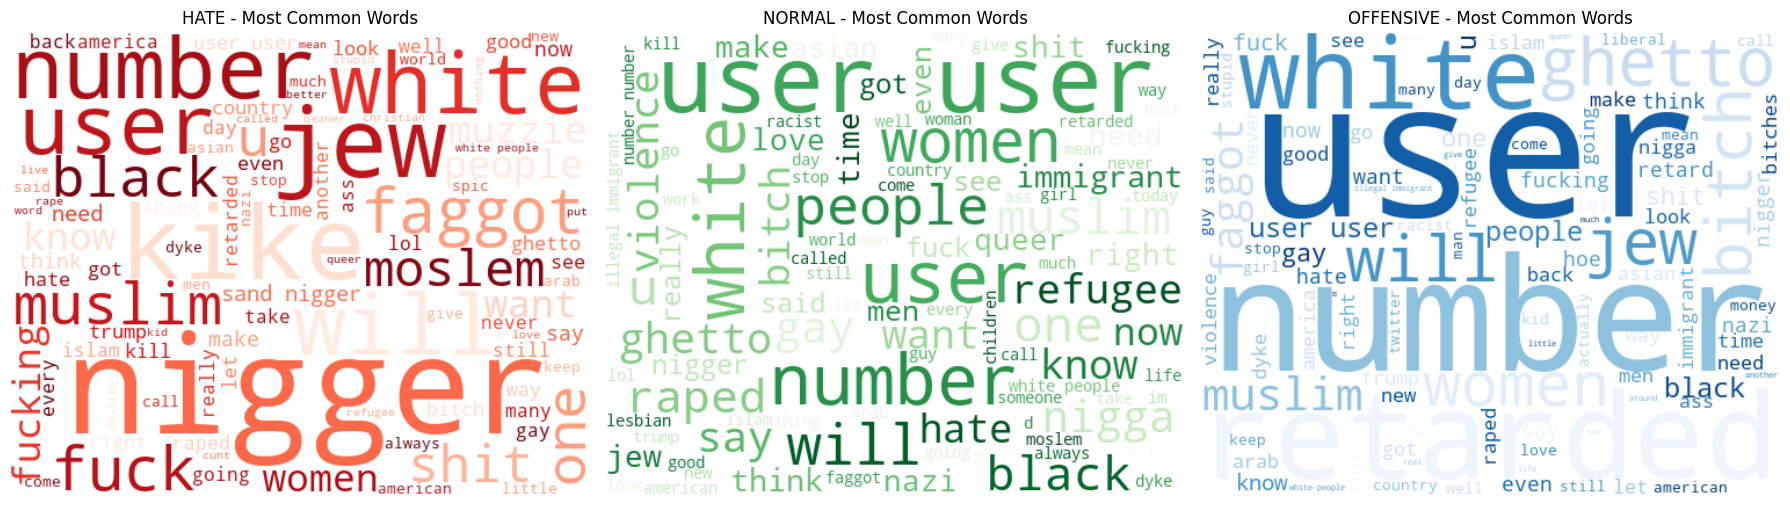

✓ Word cloud generation complete


In [17]:
def create_label_wordclouds(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    labels = ['hate', 'normal', 'offensive']
    colormaps = ['Reds', 'Greens', 'Blues']
    
    for i, (label, cmap) in enumerate(zip(labels, colormaps)):
        # Get all text for this label
        label_texts = df[df['label_name'] == label]['text'].tolist()
        all_text = ' '.join(label_texts)
        
        # Create word cloud
        wordcloud = WordCloud(
            width=500, height=400,
            background_color='white',
            colormap=cmap,
            max_words=100,
            relative_scaling=0.5
        ).generate(all_text)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{label.upper()} - Most Common Words')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

create_label_wordclouds(df)
print("✓ Word cloud generation complete")


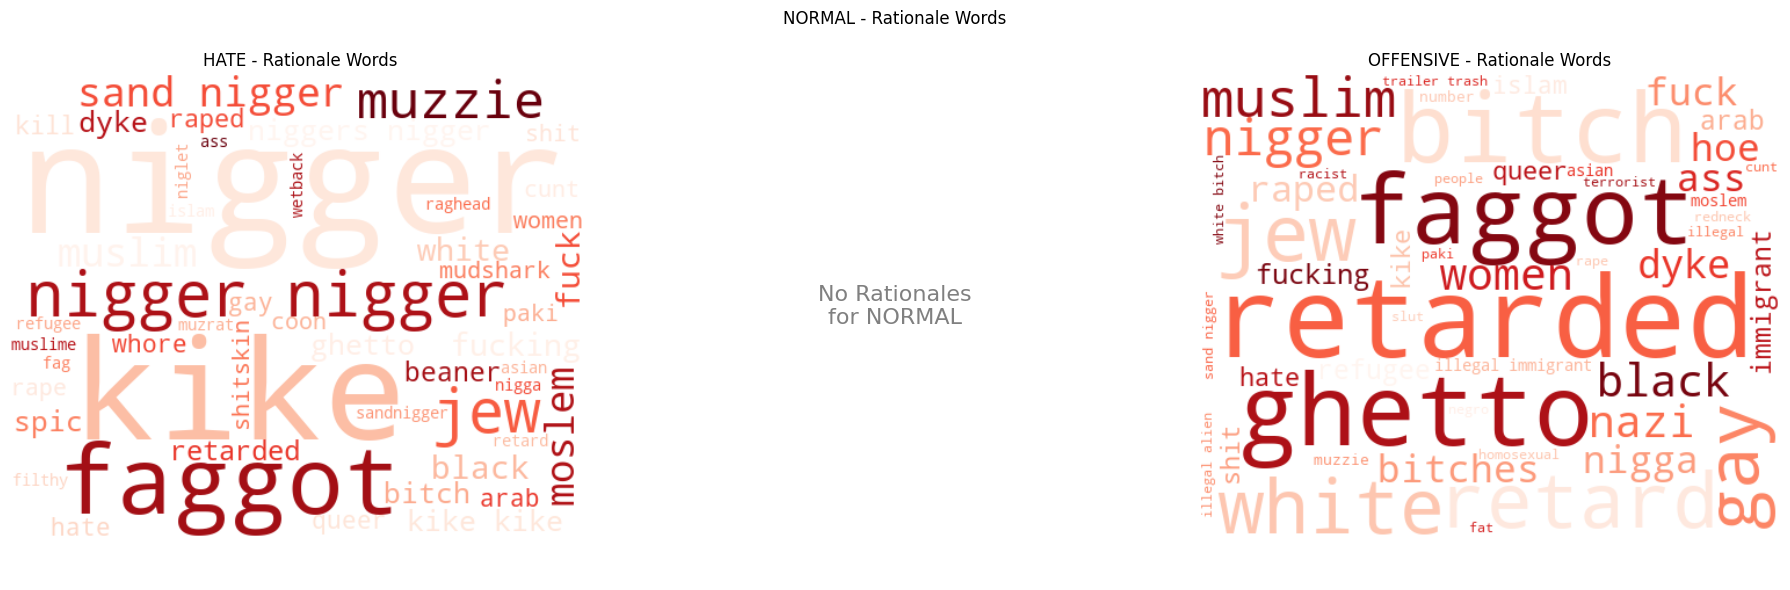

✓ Rationale word cloud generation complete


In [18]:
def create_rationale_wordclouds(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    labels = ['hate', 'normal', 'offensive']
    
    for i, label in enumerate(labels):
        rationale_words = []
        label_data = df[df['label_name'] == label]
        
        for _, row in label_data.iterrows():
            tokens = row['tokens']
            rationale_agreement = row['rationale_agreement']
            
            # Extract high-agreement rationale words
            for j, (token, agreement) in enumerate(zip(tokens, rationale_agreement)):
                if agreement > 0.5:  # High agreement threshold
                    rationale_words.append(token)
        
        if rationale_words:
            rationale_text = ' '.join(rationale_words)
            wordcloud = WordCloud(
                width=500, height=400,
                background_color='white',
                colormap='Reds',
                max_words=50
            ).generate(rationale_text)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{label.upper()} - Rationale Words')
        else:
            axes[i].text(0.5, 0.5, f'No Rationales\nfor {label.upper()}', 
                        ha='center', va='center', transform=axes[i].transAxes,
                        fontsize=16, color='gray')
            axes[i].set_title(f'{label.upper()} - Rationale Words')
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

create_rationale_wordclouds(df)
print("✓ Rationale word cloud generation complete")


In [19]:
print("=== FINAL DATASET SUMMARY ===")
print(f"Total samples: {len(df)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Label breakdown
print("\nDetailed label breakdown:")
for label in ['hate', 'normal', 'offensive']:
    label_data = df[df['label_name'] == label]
    avg_length = label_data['text_length'].mean()
    avg_confidence = label_data['confidence'].mean()
    with_targets = (label_data['targets'].str.len() > 0).sum()
    with_rationales = label_data['has_rationales'].sum()
    
    print(f"\n{label.upper()}:")
    print(f"  Count: {len(label_data)}")
    print(f"  Avg length: {avg_length:.1f} tokens")
    print(f"  Avg confidence: {avg_confidence:.3f}")
    print(f"  With targets: {with_targets}")
    print(f"  With rationales: {with_rationales}")

# Save processed data
os.makedirs('data', exist_ok=True)
df.to_pickle('data/hatexplain_processed.pkl')
df.to_csv('data/hatexplain_processed.csv', index=False)

print("\n✓ Data saved to:")
print("  - data/hatexplain_processed.pkl")  
print("  - data/hatexplain_processed.csv")

print("\n✓ Dataset ready for manual train/test/validation splitting")
print("✓ Analysis pipeline complete!")


=== FINAL DATASET SUMMARY ===
Total samples: 20148
Memory usage: 19.7 MB

Detailed label breakdown:

HATE:
  Count: 6234
  Avg length: 24.7 tokens
  Avg confidence: 0.809
  With targets: 6234
  With rationales: 5934

NORMAL:
  Count: 8153
  Avg length: 23.5 tokens
  Avg confidence: 0.862
  With targets: 8153
  With rationales: 0

OFFENSIVE:
  Count: 5761
  Avg length: 22.5 tokens
  Avg confidence: 0.752
  With targets: 5761
  With rationales: 5479

✓ Data saved to:
  - data/hatexplain_processed.pkl
  - data/hatexplain_processed.csv

✓ Dataset ready for manual train/test/validation splitting
✓ Analysis pipeline complete!


In [20]:
# Filter all posts labeled as 'normal'
normal_posts = df[df['label_name'] == 'normal']

# You might want to include all fields, or just specific ones (id, text, tokens, etc.)
# Here's an example that includes full text, tokens, and post id:
normal_posts_dict = normal_posts[['id', 'text', 'tokens', 'targets', 'confidence']].to_dict(orient='records')

import json
with open('data/normal_posts.json', 'w', encoding='utf-8') as f:
    json.dump(normal_posts_dict, f, indent=2, ensure_ascii=False)

print(f"Saved {len(normal_posts)} normal posts to data/normal_posts.json")


Saved 8153 normal posts to data/normal_posts.json


In [22]:
from sklearn.model_selection import train_test_split

# Ensure reproducibility
RANDOM_STATE = 42

# 1. Split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    df, test_size=0.2, 
    stratify=df['label'], 
    random_state=RANDOM_STATE
)

# 2. Split temp into validation (10%) and test (10%)—each is 50% of 20%
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=RANDOM_STATE
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Save splits if needed
train_df.to_csv("data/train.csv", index=False)
val_df.to_csv("data/val.csv", index=False)
test_df.to_csv("data/test.csv", index=False)


Train size: 16118
Validation size: 2015
Test size: 2015
